In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time as tt
import inspect
import importlib

# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.metrics import auc
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch_geometric.data import DataLoader
from mpl_toolkits.mplot3d import Axes3D
import itertools

from itertools import chain
from random import shuffle, sample

from torch.nn import Linear
import torch.nn.functional as F
from torch_scatter import scatter, segment_csr, scatter_add
from torch_geometric.nn.conv import MessagePassing
from torch_cluster import knn_graph, radius_graph
import trackml.dataset
import torch_geometric

sys.path.append('..')
device = "cuda" if torch.cuda.is_available() else "cpu"

# Construction

In [3]:
event_path = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021313"
feature_scale = [1000, np.pi, 1000]

In [4]:
hits, particles, truth = trackml.dataset.load_event(
        event_path, parts=['hits', 'particles', 'truth'])

In [10]:
from utils.stage_utils import get_resume_id, load_config, combo_config, dict_to_args, get_logger, build_model, build_trainer, autocast
from LightningModules.Embedding.Models.layerless_embedding import LayerlessEmbedding
from LightningModules.Embedding.utils import filter_hit_pt, fetch_pt, fetch_type, load_dataset, graph_intersection, build_edges, res

In [13]:
theta = np.arctan2(np.sqrt(particles.px**2 + particles.py**2), particles.pz)
eta =  -1. * np.log(np.tan(theta / 2.))

In [5]:
def select_hits(hits, truth, particles, pt_min=0, endcaps=False, noise=False):
    # Barrel volume and layer ids
    if endcaps:
        vlids = [(7, 2), (7, 4), (7, 6), (7, 8), (7, 10), (7, 12), (7, 14), (8, 2), (8, 4), (8, 6), (8, 8), (9, 2), (9, 4), (9, 6), (9, 8), (9, 10), (9, 12), (9, 14), (12, 2), (12, 4), (12, 6), (12, 8), (12, 10), (12, 12), (13, 2), (13, 4), (13, 6), (13, 8), (14, 2), (14, 4), (14, 6), (14, 8), (14, 10), (14, 12), (16, 2), (16, 4), (16, 6), (16, 8), (16, 10), (16, 12), (17, 2), (17, 4), (18, 2), (18, 4), (18, 6), (18, 8), (18, 10), (18, 12)]
    else:
        vlids = [(8,2), (8,4), (8,6), (8,8), (13,2), (13,4), (13,6), (13,8), (17,2), (17,4)]
    n_det_layers = len(vlids)
    # Select barrel layers and assign convenient layer number [0-9]
    vlid_groups = hits.groupby(['volume_id', 'layer_id'])
    hits = pd.concat([vlid_groups.get_group(vlids[i]).assign(layer=i)
                      for i in range(n_det_layers)])
    if noise is False:
        # Calculate particle transverse momentum
        pt = np.sqrt(particles.px**2 + particles.py**2)
        # Applies pt cut, removes noise hits
        particles = particles[pt > pt_min]
        truth = (truth[['hit_id', 'particle_id', 'tpx', 'tpy', 'weight']]
                 .merge(particles[['particle_id', 'vx', 'vy', 'vz']], on='particle_id'))
        truth = truth.assign(pt = np.sqrt(truth.tpx**2 + truth.tpy**2))
    else:
        # Calculate particle transverse momentum
        pt = np.sqrt(truth.tpx**2 + truth.tpy**2)
        # Applies pt cut
        truth = truth[pt > pt_min]
        truth.loc[truth['particle_id'] == 0,'particle_id'] = float('NaN')
        truth = truth.assign(pt = pt)
    # Calculate derived hits variables
    r = np.sqrt(hits.x**2 + hits.y**2)
    phi = np.arctan2(hits.y, hits.x)
    # Select the data columns we need
    hits = (hits[['hit_id', 'x', 'y', 'z', 'layer']]
            .assign(r=r, phi=phi)
            .merge(truth[['hit_id', 'particle_id', 'vx', 'vy', 'vz', 'pt', 'weight']], on='hit_id'))
    # (DON'T) Remove duplicate hits
#     hits = hits.loc[
#         hits.groupby(['particle_id', 'layer'], as_index=False).r.idxmin()
#     ]
    return hits

In [6]:
def build_event(event_file, pt_min, feature_scale, adjacent=True, endcaps=False, layerless=True, layerwise=True, noise=False):
    # Get true edge list using the ordering by R' = distance from production vertex of each particle
    hits, particles, truth = trackml.dataset.load_event(
        event_file, parts=['hits', 'particles', 'truth'])
    hits = select_hits(hits, truth, particles, pt_min=pt_min, endcaps=endcaps, noise=noise).assign(evtid=int(event_file[-9:]))
    layers = hits.layer.to_numpy()

    # Handle which truth graph(s) are being produced
    layerless_true_edges, layerwise_true_edges = None, None

    if layerless:
        hits = hits.assign(R=np.sqrt((hits.x - hits.vx)**2 + (hits.y - hits.vy)**2 + (hits.z - hits.vz)**2))
        hits = hits.sort_values('R').reset_index(drop=True).reset_index(drop=False)
        hit_list = hits.groupby(['particle_id', 'layer'], sort=False)['index'].agg(lambda x: list(x)).groupby(level=0).agg(lambda x: list(x))

        e = []
        for row in hit_list.values:
            for i, j in zip(row[0:-1], row[1:]):
                e.extend(list(itertools.product(i, j)))

        layerless_true_edges = np.array(e).T
#         logging.info("Layerless truth graph built for {} with size {}".format(event_file, layerless_true_edges.shape))

    if layerwise:
        # Get true edge list using the ordering of layers
        records_array = hits.particle_id.to_numpy()
        idx_sort = np.argsort(records_array)
        sorted_records_array = records_array[idx_sort]
        _, idx_start, _ = np.unique(sorted_records_array, return_counts=True,
                                return_index=True)
        # sets of indices
        res = np.split(idx_sort, idx_start[1:])
        layerwise_true_edges = np.concatenate([list(permutations(i, r=2)) for i in res if len(list(permutations(i, r=2))) > 0]).T
        if adjacent: layerwise_true_edges = layerwise_true_edges[:, (layers[layerwise_true_edges[1]] - layers[layerwise_true_edges[0]] == 1)]
#         logging.info("Layerwise truth graph built for {} with size {}".format(event_file, layerwise_true_edges.shape))

    edge_weights = hits.weight.to_numpy()[layerless_true_edges] if layerless else hits.weight.to_numpy()[layerwise_true_edges]
    edge_weight_average = (edge_weights[0] + edge_weights[1])/2
    edge_weight_norm = edge_weight_average / edge_weight_average.mean()
        
    return hits[['r', 'phi', 'z']].to_numpy() / feature_scale, hits.particle_id.to_numpy(), layers, layerless_true_edges, layerwise_true_edges, hits['hit_id'].to_numpy(), hits.pt.to_numpy(), edge_weight_norm

In [32]:
%%time
hits, pid, layers, truth, _, hid, pt, weight = build_event(event_path, 0, feature_scale, adjacent=False, endcaps=True, layerless=True, layerwise=False, noise=False)

CPU times: user 5.82 s, sys: 72.4 ms, total: 5.89 s
Wall time: 5.9 s


In [49]:
pt_min =0
adjacent=False
endcaps=True
layerless=True
layerwise=False
noise=False

In [51]:
# Get true edge list using the ordering by R' = distance from production vertex of each particle
hits, particles, truth = trackml.dataset.load_event(
    event_path, parts=['hits', 'particles', 'truth'])
hits = select_hits(hits, truth, particles, pt_min=pt_min, endcaps=endcaps, noise=noise).assign(evtid=int(event_path[-9:]))
layers = hits.layer.to_numpy()

In [52]:
hits = hits.assign(R=np.sqrt((hits.x - hits.vx)**2 + (hits.y - hits.vy)**2 + (hits.z - hits.vz)**2))

In [54]:
hits[hits.pt == hits.pt.max()]

,hit_id,x,y,z,layer,r,phi,particle_id,vx,vy,vz,pt,weight,evtid,R
91066,103117,-526.742981,-632.497009,-449.799988,40,823.110352,-2.265219,162141749932720128,-0.016207,0.011982,24.3501,7.071068e+14,0.000011,21313,949.908936
93264,107587,-668.744019,-774.533997,-655.799988,41,1023.289551,-2.283027,162141749932720128,-0.016207,0.011982,24.3501,7.071068e+14,0.000013,21313,1228.707642


In [55]:
hits = hits.sort_values('R').reset_index(drop=True).reset_index(drop=False)
hit_list = hits.groupby(['particle_id', 'layer'], sort=False)['index'].agg(lambda x: list(x)).groupby(level=0).agg(lambda x: list(x))

e = []
for row in hit_list.values:
    for i, j in zip(row[0:-1], row[1:]):
        e.extend(list(itertools.product(i, j)))

layerless_true_edges = np.array(e).T

In [56]:
layerless_true_edges

array([[ 3480,  3703,  9219, ..., 65782, 74083, 91052],
       [ 9219,  9219, 15824, ..., 74083, 91052, 93726]])

In [72]:
hit_list[hit_list.index == 162141749932720128]

particle_id
162141749932720128    [[1568, 2065], [6305], [11098], [16432], [2326...
Name: index, dtype: object

In [73]:
hits[hits.particle_id == 162141749932720128]

,index,hit_id,x,y,z,layer,r,phi,particle_id,vx,vy,vz,pt,weight,evtid,R
1568,1568,21726,-13.053200,-28.609100,9.704030,7,31.446251,-1.998844,162141749932720128,-0.016207,0.011982,24.3501,7.932551e-01,0.000021,21313,34.693470
2065,2065,21813,-14.057600,-30.696400,8.624680,7,33.762184,-2.000247,162141749932720128,-0.016207,0.011982,24.3501,7.931395e-01,0.000018,21313,37.248547
6305,6305,28042,-30.731199,-64.936600,-9.132830,8,71.841278,-2.012815,162141749932720128,-0.016207,0.011982,24.3501,7.923592e-01,0.000015,21313,79.264343
11098,11098,34812,-51.786999,-104.822998,-30.162600,9,116.917725,-2.029666,162141749932720128,-0.016207,0.011982,24.3501,7.912185e-01,0.000012,21313,129.004745
16432,16432,40757,-79.686798,-152.649002,-55.868500,10,172.196701,-2.051909,162141749932720128,-0.016207,0.011982,24.3501,7.909335e-01,0.000011,21313,189.967896
23261,23261,70432,-128.388000,-226.029999,-96.400002,24,259.948151,-2.087364,162141749932720128,-0.016207,0.011982,24.3501,7.886919e-01,0.000008,21313,286.626740
29281,29281,77030,-187.554001,-302.907990,-142.000000,25,356.272003,-2.125198,162141749932720128,-0.016207,0.011982,24.3501,7.870119e-01,0.000006,21313,393.196259
29616,29616,77012,-191.550995,-307.709991,-144.399994,25,362.459961,-2.127599,162141749932720128,-0.016207,0.011982,24.3501,7.871668e-01,0.000006,21313,399.818695
36784,36784,82794,-285.653015,-408.600006,-209.000000,26,498.549530,-2.180919,162141749932720128,-0.016207,0.011982,24.3501,7.871054e-01,0.000006,21313,550.458374
37176,37176,82789,-289.802002,-412.600006,-212.600006,26,504.206268,-2.183118,162141749932720128,-0.016207,0.011982,24.3501,7.870768e-01,0.000009,21313,557.108459


In [64]:
hits[hits.pt == hits.pt.max()]

,index,hit_id,x,y,z,layer,r,phi,particle_id,vx,vy,vz,pt,weight,evtid,R
63694,63694,103117,-526.742981,-632.497009,-449.799988,40,823.110352,-2.265219,162141749932720128,-0.016207,0.011982,24.3501,7.071068e+14,0.000011,21313,949.908936
75091,75091,107587,-668.744019,-774.533997,-655.799988,41,1023.289551,-2.283027,162141749932720128,-0.016207,0.011982,24.3501,7.071068e+14,0.000013,21313,1228.707642


In [45]:
layers[np.where(pt == pt.max())[0]]

array([24, 26])

# Truth Intersection

### Load Data

In [197]:
from utils.stage_utils import get_resume_id, load_config, combo_config, dict_to_args, get_logger, build_model, build_trainer, autocast
from LightningModules.Embedding.Models.layerless_embedding import LayerlessEmbedding
from LightningModules.Embedding.utils import filter_hit_pt, fetch_pt, load_dataset, graph_intersection, build_edges, res, reset_edge_id

In [201]:
data = torch.load('/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/feature_store_endcaps_SMALLTEST/21000')

In [199]:
data = filter_hit_pt(data.to('cpu'), pt_cut=1)[0]

In [202]:
data

Data(cell_data=[107725, 9], event_file="/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021000", hid=[107725], layerless_true_edges=[2, 129059], layers=[107725], pid=[107725], pt=[107725], weights=[129059], x=[107725, 3])

In [204]:
stage = {"set": "Embedding", "name": "LayerlessEmbedding", "config": "train_small_embedding.yaml", "resume_id": "19tpoihe"}
libraries = {
    "model_library": "/global/homes/d/danieltm/ExaTrkX/Tracking-ML-Exa.TrkX/src/Pipelines/Examples/LightningModules",
    "artifact_library": "/global/cscratch1/sd/danieltm/ExaTrkX/lightning_checkpoints"
}

In [205]:
resume_id = get_resume_id(stage)
model_config = load_config(stage, resume_id, libraries)
model_dir = os.path.join(libraries["artifact_library"], model_config["project"], resume_id)
model_name = "last.ckpt-v0.ckpt"
chkpnt = torch.load(os.path.join(model_dir, model_name))
chkpnt["hparams_name"] = "hyper_parameters"
model = LayerlessEmbedding(chkpnt["hyper_parameters"])
model.load_state_dict(chkpnt["state_dict"])
model = model.to(device)

## Test Inference

In [112]:
def graph_intersection(pred_graph, truth_graph):
    array_size = max(pred_graph.max().item(), truth_graph.max().item()) + 1

    l1 = pred_graph.cpu().numpy()
    l2 = truth_graph.cpu().numpy()
    e_1 = sp.sparse.coo_matrix((np.ones(l1.shape[1]), l1), shape=(array_size, array_size)).tocsr()
    e_2 = sp.sparse.coo_matrix((np.ones(l2.shape[1]), l2), shape=(array_size, array_size)).tocsr()
    e_intersection = (e_1.multiply(e_2) - ((e_1 - e_2)>0)).tocoo()

    new_pred_graph = torch.from_numpy(np.vstack([e_intersection.row, e_intersection.col])).long().to(device)
    y = e_intersection.data > 0

    return new_pred_graph, y

In [115]:
with torch.no_grad():
    batch = data.to(device)

    if 'ci' in model.hparams["regime"]:
        spatial = model(torch.cat([batch.cell_data, batch.x], axis=-1))
    else:
        spatial = model(batch.x)

    e_bidir = torch.cat([batch.layerless_true_edges, batch.layerless_true_edges.flip(0)], axis=-1)

    # Build whole KNN graph
    e_spatial = build_edges(spatial, 1.5, 500, res)

    e_spatial, y_cluster = graph_intersection(e_spatial, e_bidir)

    data.true_positives = e_spatial[:, y_cluster]

    cluster_true = e_bidir.shape[1]
    cluster_true_positive = y_cluster.sum()
    cluster_positive = len(e_spatial[0])

    eff = torch.tensor(cluster_true_positive / cluster_true)
    pur = torch.tensor(cluster_true_positive / cluster_positive)

In [116]:
print(eff, pur)

tensor(0.7530, dtype=torch.float64) tensor(0.0180, dtype=torch.float64)


## Develop Graph Intersection

In [234]:
with torch.no_grad():
    batch = data.to(device)

    if 'ci' in model.hparams["regime"]:
        spatial = model(torch.cat([batch.cell_data, batch.x], axis=-1))
    else:
        spatial = model(batch.x)

    e_bidir = torch.cat([batch.layerless_true_edges, batch.layerless_true_edges.flip(0)], axis=-1)
    weights_bidir = torch.cat([batch.weights, batch.weights])

    # Build whole KNN graph
    e_spatial = build_edges(spatial, 1., 500, res)

    pred_graph, truth_graph = e_spatial, e_bidir
    
    array_size = max(pred_graph.max().item(), truth_graph.max().item()) + 1

    l1 = pred_graph.cpu().numpy()
    l2 = truth_graph.cpu().numpy()
    e_1 = sp.sparse.coo_matrix((np.ones(l1.shape[1]), l1), shape=(array_size, array_size)).tocsr()
    e_2 = sp.sparse.coo_matrix((np.ones(l2.shape[1]), l2), shape=(array_size, array_size)).tocsr()
    
    e_intersection = (e_1.multiply(e_2) - ((e_1 - e_2)>0))
    
    weight_list = weights_bidir.cpu().numpy()
    weight_sparse = sp.sparse.coo_matrix((weight_list, l2), shape=(array_size, array_size)).tocsr()
    new_weights = weight_sparse[e_intersection.astype('bool')]
    new_weights = torch.from_numpy(np.array(new_weights)[0])

    e_intersection = e_intersection.tocoo()    
    new_pred_graph = torch.from_numpy(np.vstack([e_intersection.row, e_intersection.col])).long().to(device)
    y = e_intersection.data > 0

    cluster_true = e_bidir.shape[1]
    cluster_true_positive = y.sum()
    cluster_positive = len(new_pred_graph[0])

    eff = torch.tensor(cluster_true_positive / cluster_true)
    pur = torch.tensor(cluster_true_positive / cluster_positive)

In [235]:
e_spatial = torch.cat([e_spatial, e_bidir.transpose(0,1).repeat(1,2).view(-1, 2).transpose(0,1)], axis=-1)

In [236]:
e_spatial.shape

torch.Size([2, 4495903])

In [237]:
new_weights = torch.cat([new_weights.to(device), weights_bidir.repeat(2)], axis=-1)

In [238]:
new_weights.shape

torch.Size([4495903])

In [142]:
pred_graph.shape

torch.Size([2, 3979667])

In [139]:
data.weights[data.weights > 0].shape

torch.Size([119413])

In [122]:
%%time

e_intersection = (e_1.multiply(e_2) - ((e_1 - e_2)>0))

CPU times: user 86.4 ms, sys: 22 ms, total: 108 ms
Wall time: 107 ms


In [127]:
%%time
e_intersection.tocoo()

CPU times: user 28.3 ms, sys: 44.4 ms, total: 72.7 ms
Wall time: 72.7 ms


<107725x107725 sparse matrix of type '<class 'numpy.float64'>'
	with 3979667 stored elements in COOrdinate format>

In [93]:
pred_graph

tensor([[    0,     0,     1,  ..., 15197, 15197, 15197],
        [ 1850,  2748,   501,  ..., 15196, 15195, 14789]], device='cuda:0')

In [65]:
new_pred_graph

tensor([[    0,     0,     1,  ..., 15197, 15197, 15197],
        [ 1850,  2748,   501,  ..., 14789, 15195, 15196]], device='cuda:0')

In [96]:
y

array([False, False,  True, ...,  True, False, False])

In [101]:
np.vstack([e_2.tocoo().row, e_2.tocoo().col])

array([[    0,     1,     2, ..., 15195, 15196, 15197],
       [  626,   501,   590, ..., 14789, 14789, 14789]], dtype=int32)

In [106]:
weights_bidir[e_bidir[0] == 15197]

tensor([0.0654], device='cuda:0')

In [95]:
weights_bidir

tensor([0.2169, 0.1792, 0.1462,  ..., 0.0957, 0.1115, 0.1311], device='cuda:0')

In [129]:
weight_sparse[e_intersection.astype('bool')]

IndexError: index (107724) out of range

In [68]:
data.weights

tensor([0.2169, 0.1792, 0.1462,  ..., 0.0957, 0.1115, 0.1311], device='cuda:0')

In [77]:
weights_bidir = torch.cat([data.weights, data.weights])

In [78]:
weight_list = weights_bidir.cpu().numpy()

In [81]:
weight_sparse = sp.sparse.coo_matrix((weight_list, l2), shape=(array_size, array_size)).tocsr()

In [89]:
weight_sparse

<15198x15198 sparse matrix of type '<class 'numpy.float32'>'
	with 36220 stored elements in Compressed Sparse Row format>

In [90]:
e_intersection.astype('bool')

<15198x15198 sparse matrix of type '<class 'numpy.bool_'>'
	with 69872 stored elements in Compressed Sparse Row format>

## Test Train Weighting

In [ ]:
if 'ci' in self.hparams["regime"]:
            spatial = self(torch.cat([batch.cell_data, batch.x], axis=-1))
        else:
            spatial = self(batch.x)

        e_bidir = torch.cat([batch.layerless_true_edges, batch.layerless_true_edges.flip(0)], axis=-1)

        e_spatial = torch.empty([2,0], dtype=torch.int64, device=self.device)

        if 'rp' in self.hparams["regime"]:
        # Get random edge list
            n_random = int(self.hparams["randomisation"]*e_bidir.shape[1])
            e_spatial = torch.cat([e_spatial, torch.randint(e_bidir.min(), e_bidir.max(), (2, n_random), device=self.device)], axis=-1)

        if 'hnm' in self.hparams["regime"]:
            e_spatial = (torch.cat([e_spatial, build_edges(spatial, self.hparams["r_train"], self.hparams["knn"], res)], axis=-1)
                        if torch.cuda.is_available()
                        else torch.cat([e_spatial, radius_graph(spatial, r=self.hparams["r_train"], max_num_neighbors=self.hparams["knn"])], axis=-1))

        if "weighting" in self.hparams["regime"]:
            weights_bidir = torch.cat([batch.weights, batch.weights])
            e_spatial, y_cluster, new_weights = graph_intersection(e_spatial, e_bidir, using_weights=True, weights_bidir=weights_bidir)
            new_weights = new_weights.to(self.device) * self.hparams["weight"] # Weight positive examples
        else:
            e_spatial, y_cluster = graph_intersection(e_spatial, e_bidir)
            new_weights = y_cluster * self.hparams["weight"]
        
        new_weights[y_cluster == 0] = 1 # Give negative examples a weight of 1 (note that there may still be TRUE examples that are weightless)

#         e_spatial = torch.cat([e_spatial, e_bidir.transpose(0,1).repeat(1,self.hparams["weight"]).view(-1, 2).transpose(0,1)], axis=-1)
#         y_cluster = np.concatenate([y_cluster.astype(int), np.ones(e_bidir.shape[1]*self.hparams["weight"])])

        hinge = y_cluster.float()
        hinge[hinge == 0] = -1

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])
        d = torch.sum((reference - neighbors)**2, dim=-1)
        d = d * new_weights

        loss = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=self.hparams["margin"], reduction="mean")

        self.log('train_loss', loss)

# Embedding Weighted Performance

1. Define weighted performance
2. Load unweighted model, show score
3. Load weighted model, show score

## Load Model

In [3]:
def stats(lst):
    return {"mean": np.mean(lst), "st.dev": np.std(lst)}

In [4]:
from utils.stage_utils import get_resume_id, load_config, combo_config, dict_to_args, get_logger, build_model, build_trainer, autocast
from LightningModules.Embedding.Models.layerless_embedding import LayerlessEmbedding
from LightningModules.Embedding.utils import filter_hit_pt, fetch_pt, load_dataset, graph_intersection, build_edges, res

In [65]:
stage = {"set": "Embedding", "name": "LayerlessEmbedding", "config": "train_coda_small_embedding.yaml", "resume_id": "suvpgvg8"}
libraries = {
    "model_library": "/global/homes/d/danieltm/ExaTrkX/Tracking-ML-Exa.TrkX/src/Pipelines/Examples/LightningModules",
    "artifact_library": "/global/cscratch1/sd/danieltm/ExaTrkX/lightning_checkpoints"
}

In [66]:
resume_id = get_resume_id(stage)

In [67]:
model_config = load_config(stage, resume_id, libraries)

In [13]:
model_dir = os.path.join(libraries["artifact_library"], model_config["project"], resume_id)
model_name = "last.ckpt-v1.ckpt"

In [14]:
model = LayerlessEmbedding.load_from_checkpoint(os.path.join(model_dir, model_name)).to(device)

NameError: name 'LayerlessEmbedding' is not defined

In [10]:
model.setup("fit")

In [11]:
test_set = model.testset

## Weightless model

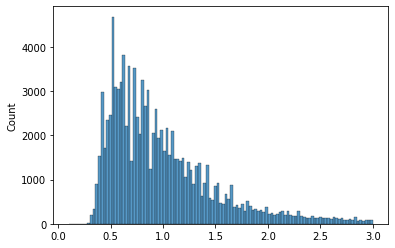

In [105]:
sns.histplot(test_set[0].weights.cpu().numpy(), binrange=(0.1, 3))

In [58]:
%%time
weighted_tp = []
weighted_t = []
weighted_p = []
tp_list = []
t_list = []
p_list = []

with torch.no_grad():
    for i, data in enumerate(test_set.dataset[:100]):
        
        batch = data.to(device)

        if 'ci' in model.hparams["regime"]:
            spatial = model(torch.cat([batch.cell_data, batch.x], axis=-1))
        else:
            spatial = model(batch.x)

        # Build whole KNN graph
        e_spatial = build_edges(spatial, 1.85, 300, res)

        e_bidir = torch.cat([batch.layerless_true_edges, batch.layerless_true_edges.flip(0)], axis=-1)
        weights_bidir = torch.cat([batch.weights, batch.weights])

        e_spatial, y_cluster, new_weights = graph_intersection(e_spatial, e_bidir, using_weights=True, weights_bidir=weights_bidir)
        new_weights = new_weights.to(device)
        
        weighted_tp.append(new_weights.sum().item())
        weighted_t.append(weights_bidir.sum().item())
        weighted_p.append(new_weights.sum().item() + (~y_cluster).sum().item())
        t_list.append(e_bidir.shape[1])
        tp_list.append(y_cluster.sum().item())
        p_list.append(len(e_spatial[0]))
        

CPU times: user 2min 47s, sys: 1min 41s, total: 4min 28s
Wall time: 4min 12s


In [59]:
eff_list, pur_list = np.array(tp_list) / np.array(t_list), np.array(tp_list) / np.array(p_list)
weighted_eff, weighted_pur = np.array(weighted_tp) / np.array(weighted_t), np.array(weighted_tp) / np.array(weighted_p)

In [60]:
print(stats(eff_list))
print(stats(pur_list))
print(stats(weighted_eff))
print(stats(weighted_pur))
print(stats(weighted_tp))

{'mean': 0.9708377159014665, 'st.dev': 0.0018259698523645604}
{'mean': 0.016401625927863435, 'st.dev': 0.0015570255279057743}
{'mean': 0.9902625186284297, 'st.dev': 0.001029258756145663}
{'mean': 0.016722416843600332, 'st.dev': 0.0015662484882566182}
{'mean': 219085.92859375, 'st.dev': 27369.3191101115}


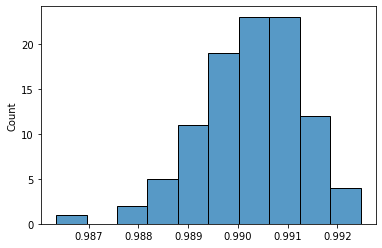

In [61]:
sns.histplot(weighted_eff)

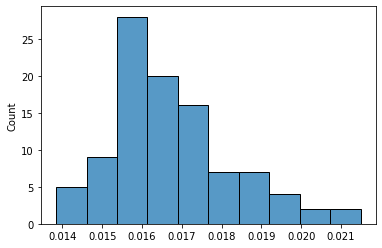

In [62]:
sns.histplot(weighted_pur)

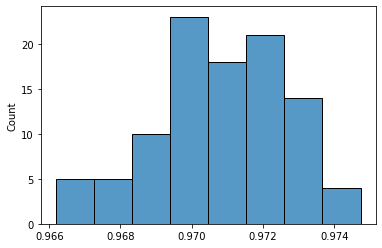

In [63]:
sns.histplot(eff_list)

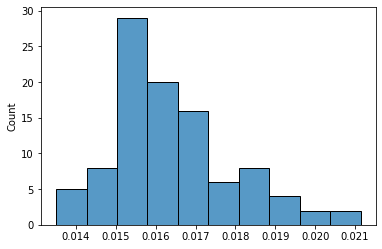

In [64]:
sns.histplot(pur_list)

## Weighted model

In [171]:
%%time
weighted_tp2 = []
weighted_t2 = []
weighted_p2 = []
tp_list2 = []
t_list2 = []
p_list2 = []

with torch.no_grad():
    for i, data in enumerate(test_set.dataset[:100]):
        
        batch = data.to(device)

        if 'ci' in model.hparams["regime"]:
            spatial = model(torch.cat([batch.cell_data, batch.x], axis=-1))
        else:
            spatial = model(batch.x)

        # Build whole KNN graph
        e_spatial = build_edges(spatial, 1.95, 500, res)

        e_bidir = torch.cat([batch.layerless_true_edges, batch.layerless_true_edges.flip(0)], axis=-1)
        weights_bidir = torch.cat([batch.weights, batch.weights])

        e_spatial, y_cluster, new_weights = graph_intersection(e_spatial, e_bidir, using_weights=True, weights_bidir=weights_bidir)
        new_weights = new_weights.to(device)
        
        weighted_tp2.append(new_weights.sum().item())
        weighted_t2.append(weights_bidir.sum().item())
        weighted_p2.append(new_weights.sum().item() + (~y_cluster).sum().item())
        t_list2.append(e_bidir.shape[1])
        tp_list2.append(y_cluster.sum().item())
        p_list2.append(len(e_spatial[0]))
        

CPU times: user 2min 27s, sys: 1min 32s, total: 3min 59s
Wall time: 3min 40s


In [172]:
eff_list2, pur_list2 = np.array(tp_list2) / np.array(t_list2), np.array(tp_list2) / np.array(p_list2)
weighted_eff2, weighted_pur2 = np.array(weighted_tp2) / np.array(weighted_t2), np.array(weighted_tp2) / np.array(weighted_p2)

In [173]:
print(stats(eff_list2))
print(stats(pur_list2))
print(stats(weighted_eff2))
print(stats(weighted_pur2))
print(stats(weighted_tp2))

{'mean': 0.9389585187922951, 'st.dev': 0.0024056098423216967}
{'mean': 0.019762753855241292, 'st.dev': 0.002509433987422748}
{'mean': 0.9901436909587648, 'st.dev': 0.0012735681376005589}
{'mean': 0.020816219600608647, 'st.dev': 0.002630377065783889}
{'mean': 219068.59328125, 'st.dev': 27439.174381085653}


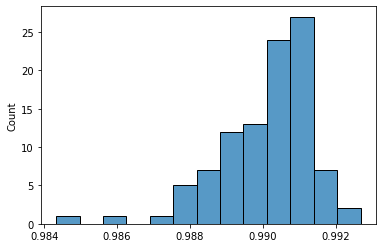

In [174]:
sns.histplot(weighted_eff2)

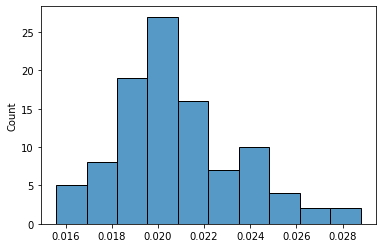

In [175]:
sns.histplot(weighted_pur2)

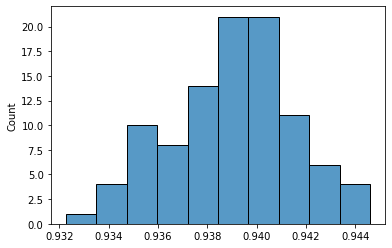

In [176]:
sns.histplot(eff_list2)

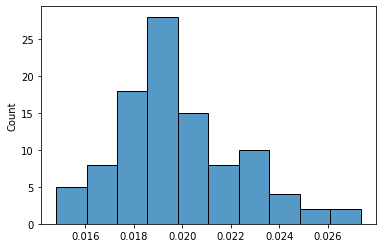

In [177]:
sns.histplot(pur_list2)

### Compare

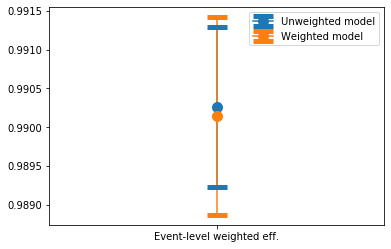

In [178]:
x = np.array(["Event-level weighted eff."])
y = np.array([stats(weighted_eff)["mean"]])
e = np.array([stats(weighted_eff)["st.dev"]])
plt.errorbar(x, y, e, capsize = 10, capthick=5, marker=".", ms = 20, label="Unweighted model")
x = np.array(["Event-level weighted eff."])
y = np.array([stats(weighted_eff2)["mean"]])
e = np.array([stats(weighted_eff2)["st.dev"]])
plt.errorbar(x, y, e, capsize = 10, capthick=5, marker=".", ms = 20, label="Weighted model")
plt.legend()

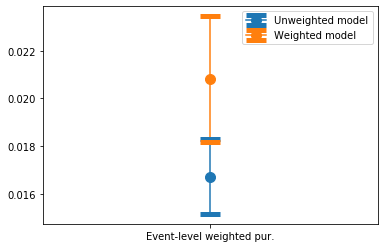

In [179]:
x = np.array(["Event-level weighted pur."])
y = np.array([stats(weighted_pur)["mean"]])
e = np.array([stats(weighted_pur)["st.dev"]])
plt.errorbar(x, y, e, capsize = 10, capthick=5, marker=".", ms = 20, label="Unweighted model")
x = np.array(["Event-level weighted pur."])
y = np.array([stats(weighted_pur2)["mean"]])
e = np.array([stats(weighted_pur2)["st.dev"]])
plt.errorbar(x, y, e, capsize = 10, capthick=5, marker=".", ms = 20, label="Weighted model")
plt.legend()

# Filter Weighted Performance

1. Define weighted performance
2. Load unweighted model, show score
3. Load weighted model, show score

## Load Model

In [3]:
def stats(lst):
    return {"mean": np.mean(lst), "st.dev": np.std(lst)}

In [4]:
from utils.stage_utils import get_resume_id, load_config, combo_config, dict_to_args, get_logger, build_model, build_trainer, autocast
from LightningModules.Filter.Models.vanilla_filter import VanillaFilter
from LightningModules.Embedding.utils import filter_hit_pt, fetch_pt, load_dataset, graph_intersection, build_edges, res

In [137]:
# stage = {"set": "Filter", "name": "VanillaFilter", "config": "train_coda_filter.yaml", "resume_id": "eqzrkf4q"}
# stage = {"set": "Filter", "name": "VanillaFilter", "config": "train_coda_filter.yaml", "resume_id": "hljjez3w"}
stage = {"set": "Filter", "name": "VanillaFilter", "config": "train_coda_filter.yaml", "resume_id": "4vvq72tn"}

libraries = {
    "model_library": "/global/homes/d/danieltm/ExaTrkX/Tracking-ML-Exa.TrkX/src/Pipelines/Examples/LightningModules",
    "artifact_library": "/global/cscratch1/sd/danieltm/ExaTrkX/lightning_checkpoints"
}

In [138]:
resume_id = get_resume_id(stage)
model_config = load_config(stage, resume_id, libraries)
model_dir = os.path.join(libraries["artifact_library"], model_config["project"], resume_id)
model_name = "last.ckpt-v0.ckpt"
# model_name = "last.ckpt"

### Manual Load

In [139]:
chkpnt = torch.load(os.path.join(model_dir, model_name))
chkpnt["hparams_name"] = "hyper_parameters"
model = VanillaFilter(chkpnt["hyper_parameters"])
model.load_state_dict(chkpnt["state_dict"])
model = model.to(device)

In [140]:
model.setup("fit")

In [141]:
test_set = model.testset

### Auto Load

In [133]:
model = VanillaFilter.load_from_checkpoint(os.path.join(model_dir, model_name)).to(device)

In [134]:
model.setup("fit")

In [135]:
test_set = model.testset

## Embedding Weightless, Filter Weightless model

In [136]:
print("Initial eff:", np.mean([(data.weights.sum() / data.true_weights.sum()).item() for data in test_set]))

Initial eff: 0.9886672472953797


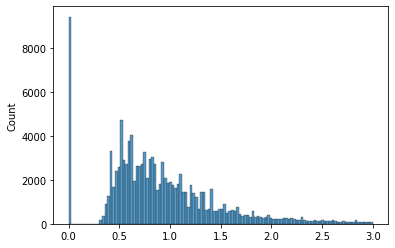

In [15]:
sns.histplot(test_set[0].true_weights.cpu().numpy(), binrange=(0, 3))

In [97]:
%%time
weighted_tp = []
weighted_t= []
weighted_t_rel = []
weighted_p = []
tp_list = []
t_list = []
t_rel_list = []
p_list = []

with torch.no_grad():
    for i, data in enumerate(test_set[:50]):
        
        batch = data.to(device)
        
        emb = None        
        
        sections = 8
        cut_list = []
        val_loss = torch.tensor(0)
        for j in range(sections):
            subset_ind = torch.chunk(torch.arange(batch.e_radius.shape[1]), sections)[j]
            output = model(torch.cat([batch.cell_data, batch.x], axis=-1), batch.e_radius[:, subset_ind], emb).squeeze()
            cut = F.sigmoid(output) > 0.033
            cut_list.append(cut)
            
            if 'weighting' in model.hparams['regime']:
                manual_weights = batch.weights[subset_ind]
                manual_weights[batch.y[subset_ind] == 0] = 1
            else:
                manual_weights = None
                
        cut_list = torch.cat(cut_list)   
        
        
        new_weights = batch.weights[cut_list]
        
        
        weighted_tp.append(new_weights.sum().item())
        weighted_t_rel.append(batch.weights.sum().item())
        weighted_t.append(batch.true_weights.sum().item())
        weighted_p.append(new_weights.sum().item() + (~batch.y[cut_list]).sum().item())
        tp_list.append(batch.y[cut_list].sum().item())
        t_list.append(batch.layerless_true_edges.shape[1])
        t_rel_list.append(batch.y.sum().item())
        p_list.append(cut_list.sum().item())

CPU times: user 15.9 s, sys: 4.03 s, total: 19.9 s
Wall time: 16.5 s


In [98]:
rel_eff_list, eff_list, pur_list = np.array(tp_list) / np.array(t_rel_list), np.array(tp_list) / np.array(t_list), np.array(tp_list) / np.array(p_list)
weighted_rel_eff, weighted_eff, weighted_pur = np.array(weighted_tp) / np.array(weighted_t_rel), np.array(weighted_tp) / np.array(weighted_t), np.array(weighted_tp) / np.array(weighted_p)

In [99]:
print("Absolute eff:", stats(eff_list))
print("Relative eff:", stats(rel_eff_list))
print("Absolute pur:", stats(pur_list))
print("Weighted eff:", stats(weighted_eff))
print("Weighted rel eff:", stats(weighted_rel_eff))
print("Weighted pur:", stats(weighted_pur))

Absolute eff: {'mean': 0.9333848011731922, 'st.dev': 0.0028048943853486367}
Relative eff: {'mean': 0.9961341062018101, 'st.dev': 0.0002710268284792541}
Absolute pur: {'mean': 0.11113557705432481, 'st.dev': 0.00967292335592655}
Weighted eff: {'mean': 0.9851627272789192, 'st.dev': 0.0013164146863729853}
Weighted rel eff: {'mean': 0.9958928288338703, 'st.dev': 0.0003101421901124723}
Weighted pur: {'mean': 0.11658081155511535, 'st.dev': 0.0101450957903617}


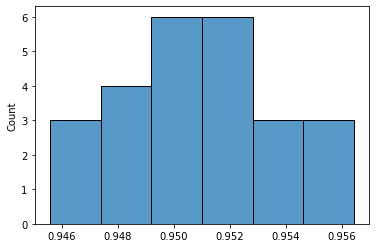

In [19]:
sns.histplot(weighted_eff)

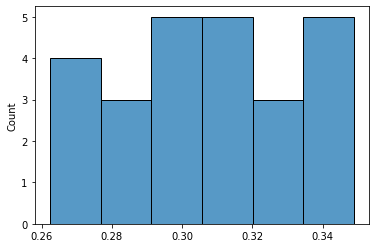

In [20]:
sns.histplot(weighted_pur)

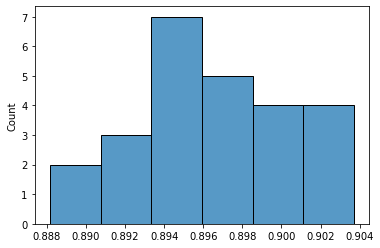

In [21]:
sns.histplot(eff_list)

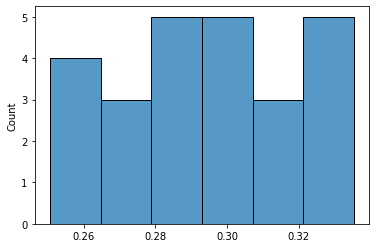

In [22]:
sns.histplot(pur_list)

## Embedding Weighted, Filter Weightless ("Semi-weighted") model

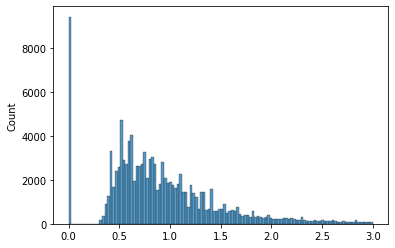

In [15]:
sns.histplot(test_set[0].true_weights.cpu().numpy(), binrange=(0, 3))

In [97]:
%%time
weighted_tp = []
weighted_t= []
weighted_t_rel = []
weighted_p = []
tp_list = []
t_list = []
t_rel_list = []
p_list = []

with torch.no_grad():
    for i, data in enumerate(test_set[:50]):
        
        batch = data.to(device)
        
        emb = None        
        
        sections = 8
        cut_list = []
        val_loss = torch.tensor(0)
        for j in range(sections):
            subset_ind = torch.chunk(torch.arange(batch.e_radius.shape[1]), sections)[j]
            output = model(torch.cat([batch.cell_data, batch.x], axis=-1), batch.e_radius[:, subset_ind], emb).squeeze()
            cut = F.sigmoid(output) > 0.033
            cut_list.append(cut)
            
            if 'weighting' in model.hparams['regime']:
                manual_weights = batch.weights[subset_ind]
                manual_weights[batch.y[subset_ind] == 0] = 1
            else:
                manual_weights = None
                
        cut_list = torch.cat(cut_list)   
        
        
        new_weights = batch.weights[cut_list]
        
        
        weighted_tp.append(new_weights.sum().item())
        weighted_t_rel.append(batch.weights.sum().item())
        weighted_t.append(batch.true_weights.sum().item())
        weighted_p.append(new_weights.sum().item() + (~batch.y[cut_list]).sum().item())
        tp_list.append(batch.y[cut_list].sum().item())
        t_list.append(batch.layerless_true_edges.shape[1])
        t_rel_list.append(batch.y.sum().item())
        p_list.append(cut_list.sum().item())

CPU times: user 15.9 s, sys: 4.03 s, total: 19.9 s
Wall time: 16.5 s


In [98]:
rel_eff_list, eff_list, pur_list = np.array(tp_list) / np.array(t_rel_list), np.array(tp_list) / np.array(t_list), np.array(tp_list) / np.array(p_list)
weighted_rel_eff, weighted_eff, weighted_pur = np.array(weighted_tp) / np.array(weighted_t_rel), np.array(weighted_tp) / np.array(weighted_t), np.array(weighted_tp) / np.array(weighted_p)

In [99]:
print("Absolute eff:", stats(eff_list))
print("Relative eff:", stats(rel_eff_list))
print("Absolute pur:", stats(pur_list))
print("Weighted eff:", stats(weighted_eff))
print("Weighted rel eff:", stats(weighted_rel_eff))
print("Weighted pur:", stats(weighted_pur))

Absolute eff: {'mean': 0.9333848011731922, 'st.dev': 0.0028048943853486367}
Relative eff: {'mean': 0.9961341062018101, 'st.dev': 0.0002710268284792541}
Absolute pur: {'mean': 0.11113557705432481, 'st.dev': 0.00967292335592655}
Weighted eff: {'mean': 0.9851627272789192, 'st.dev': 0.0013164146863729853}
Weighted rel eff: {'mean': 0.9958928288338703, 'st.dev': 0.0003101421901124723}
Weighted pur: {'mean': 0.11658081155511535, 'st.dev': 0.0101450957903617}


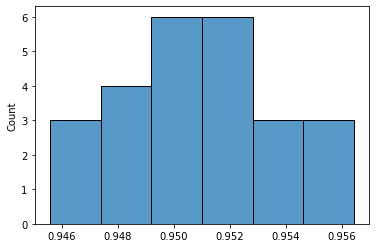

In [19]:
sns.histplot(weighted_eff)

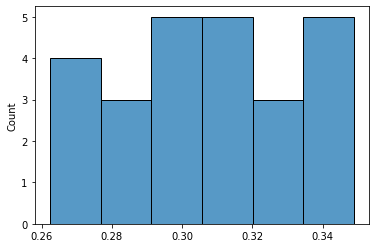

In [20]:
sns.histplot(weighted_pur)

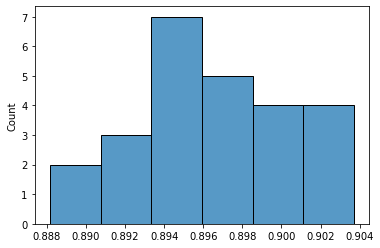

In [21]:
sns.histplot(eff_list)

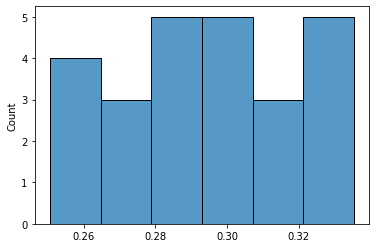

In [22]:
sns.histplot(pur_list)

## Embedding Weighted, Filter Weighted model

Inital metrics:

In [146]:
print("Initial eff:", np.mean([(data.weights.sum() / data.true_weights.sum()).item() for data in test_set]))

Initial eff: 0.9892255926132202


In [174]:
%%time
weighted_tp2 = []
weighted_t2 = []
weighted_t_rel2 = []
weighted_p2 = []
tp_list2 = []
t_list2 = []
t_rel_list2 = []
p_list2 = []

with torch.no_grad():
    for i, data in enumerate(test_set[:50]):
        
        batch = data.to(device)
        
        emb = None        
        
        sections = 8
        cut_list = []
        val_loss = torch.tensor(0)
        for j in range(sections):
            subset_ind = torch.chunk(torch.arange(batch.e_radius.shape[1]), sections)[j]
            output = model(torch.cat([batch.cell_data, batch.x], axis=-1), batch.e_radius[:, subset_ind], emb).squeeze()
            cut = F.sigmoid(output) > 0.0253
            cut_list.append(cut)
            
            if 'weighting' in model.hparams['regime']:
                manual_weights = batch.weights[subset_ind]
                manual_weights[batch.y[subset_ind] == 0] = 1
            else:
                manual_weights = None
                
        cut_list = torch.cat(cut_list)   
        
        
        new_weights = batch.weights[cut_list]
        
        
        weighted_tp2.append(new_weights.sum().item())
        weighted_t_rel2.append(batch.weights.sum().item())
        weighted_t2.append(batch.true_weights.sum().item())
        weighted_p2.append(new_weights.sum().item() + (~batch.y[cut_list]).sum().item())
        tp_list2.append(batch.y[cut_list].sum().item())
        t_list2.append(batch.layerless_true_edges.shape[1])
        t_rel_list2.append(batch.y.sum().item())
        p_list2.append(cut_list.sum().item())
        

CPU times: user 17.2 s, sys: 6.02 s, total: 23.3 s
Wall time: 18.7 s


In [175]:
rel_eff_list2, eff_list2, pur_list2 = np.array(tp_list2) / np.array(t_rel_list2), np.array(tp_list2) / np.array(t_list2), np.array(tp_list2) / np.array(p_list2)
weighted_rel_eff2, weighted_eff2, weighted_pur2 = np.array(weighted_tp2) / np.array(weighted_t_rel2), np.array(weighted_tp2) / np.array(weighted_t2), np.array(weighted_tp2) / np.array(weighted_p2)

In [176]:
print("Absolute eff:", stats(eff_list2))
print("Relative eff:", stats(rel_eff_list2))
print("Absolute pur:", stats(pur_list2))
print("Weighted eff:", stats(weighted_eff2))
print("Weighted rel eff:", stats(weighted_rel_eff2))
print("Weighted pur:", stats(weighted_pur2))

Absolute eff: {'mean': 0.931870814807417, 'st.dev': 0.0028017010309149184}
Relative eff: {'mean': 0.9945183620173375, 'st.dev': 0.0003585156723694211}
Absolute pur: {'mean': 0.11141927871195868, 'st.dev': 0.009939321374937556}
Weighted eff: {'mean': 0.9851711194099305, 'st.dev': 0.0012660190356823854}
Weighted rel eff: {'mean': 0.9959013833891904, 'st.dev': 0.00032352706290338345}
Weighted pur: {'mean': 0.1170449556645385, 'st.dev': 0.010437984621817926}


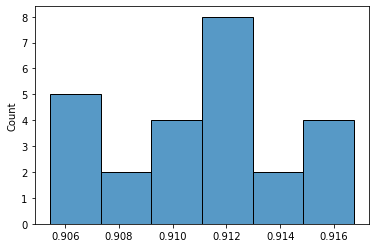

In [45]:
sns.histplot(weighted_eff2)

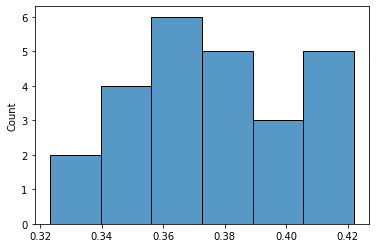

In [46]:
sns.histplot(weighted_pur2)

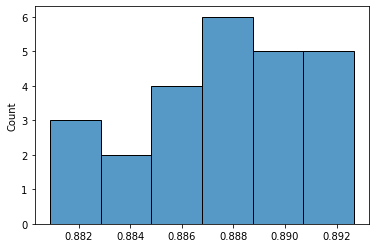

In [47]:
sns.histplot(eff_list2)

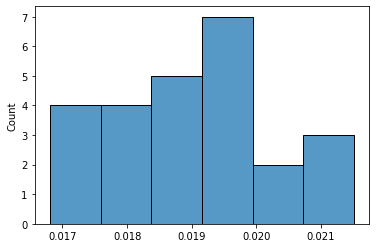

In [48]:
sns.histplot(pur_list2)

### Compare

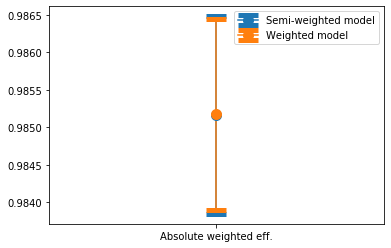

In [177]:
x = np.array(["Absolute weighted eff."])
y = np.array([stats(weighted_eff)["mean"]])
e = np.array([stats(weighted_eff)["st.dev"]])
plt.errorbar(x, y, e, capsize = 10, capthick=5, marker=".", ms = 20, label="Semi-weighted model")
x = np.array(["Absolute weighted eff."])
y = np.array([stats(weighted_eff2)["mean"]])
e = np.array([stats(weighted_eff2)["st.dev"]])
plt.errorbar(x, y, e, capsize = 10, capthick=5, marker=".", ms = 20, label="Weighted model")
plt.legend()

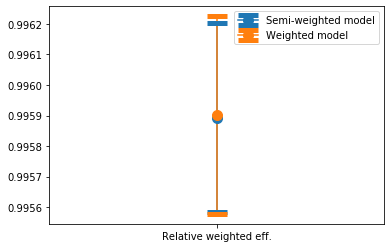

In [178]:
x = np.array(["Relative weighted eff."])
y = np.array([stats(weighted_rel_eff)["mean"]])
e = np.array([stats(weighted_rel_eff)["st.dev"]])
plt.errorbar(x, y, e, capsize = 10, capthick=5, marker=".", ms = 20, label="Semi-weighted model")
x = np.array(["Relative weighted eff."])
y = np.array([stats(weighted_rel_eff2)["mean"]])
e = np.array([stats(weighted_rel_eff2)["st.dev"]])
plt.errorbar(x, y, e, capsize = 10, capthick=5, marker=".", ms = 20, label="Weighted model")
plt.legend()

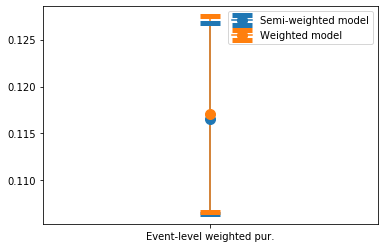

In [179]:
x = np.array(["Event-level weighted pur."])
y = np.array([stats(weighted_pur)["mean"]])
e = np.array([stats(weighted_pur)["st.dev"]])
plt.errorbar(x, y, e, capsize = 10, capthick=5, marker=".", ms = 20, label="Semi-weighted model")
x = np.array(["Event-level weighted pur."])
y = np.array([stats(weighted_pur2)["mean"]])
e = np.array([stats(weighted_pur2)["st.dev"]])
plt.errorbar(x, y, e, capsize = 10, capthick=5, marker=".", ms = 20, label="Weighted model")
plt.legend()

## Build Example Graph for SNN Folks

In [182]:
data = test_set[10]

In [194]:
data

Data(cell_data=[85335, 9], e_radius=[2, 4279575], event_file="/global/cscratch1/sd/danieltm/ExaTrkX/trackml-codalab/train_all/event000021136", hid=[85335], layerless_true_edges=[2, 101873], layers=[85335], pid=[85335], pt=[85335], true_weights=[101873], weights=[4279575], x=[85335, 3], y=[4279575])

In [188]:
with torch.no_grad():
    batch = data.to(device)        
    emb = None        

    sections = 8
    cut_list = []
    score_list = []
    val_loss = torch.tensor(0)
    for j in range(sections):
        subset_ind = torch.chunk(torch.arange(batch.e_radius.shape[1]), sections)[j]
        output = model(torch.cat([batch.cell_data, batch.x], axis=-1), batch.e_radius[:, subset_ind], emb).squeeze()
        score_list.append(F.sigmoid(output))

        if 'weighting' in model.hparams['regime']:
            manual_weights = batch.weights[subset_ind]
            manual_weights[batch.y[subset_ind] == 0] = 1
        else:
            manual_weights = None

    score_list = torch.cat(score_list)   

In [189]:
score_list.shape

torch.Size([4279575])

In [192]:
score_list.cpu().numpy()

array([0.00595626, 0.00476326, 0.07221313, ..., 0.00032479, 0.00299806,
       0.00035863], dtype=float32)

In [185]:
cut_list.shape

torch.Size([4279575])

In [197]:
graph = {"scores": score_list.cpu().numpy(), "candidate_edges": data.e_radius.cpu().numpy(), "hits_x": data.x.cpu().numpy(), "true_edges": data.layerless_true_edges.cpu().numpy(), "truth_labels": data.y.cpu().numpy(), "hits_particle_id": data.pid.cpu().numpy(), "hits_pt": data.pt.cpu().numpy()}

In [199]:
graph

{'scores': array([0.00595626, 0.00476326, 0.07221313, ..., 0.00032479, 0.00299806,
        0.00035863], dtype=float32),
 'candidate_edges': array([[    0,     0,  6782, ..., 85333, 83306, 84859],
        [ 6521,  6654,     0, ..., 82942, 85334, 85334]]),
 'hits_x': array([[ 0.07215654, -0.6532226 ,  0.277569  ],
        [ 0.11525259, -0.8157914 , -0.10912   ],
        [ 0.07140328, -0.5809555 ,  0.33644602],
        ...,
        [ 0.8594338 , -0.19492304,  2.1445    ],
        [ 0.39992845,  0.4740874 ,  2.5515    ],
        [ 0.25995743,  0.52596563,  2.9455    ]], dtype=float32),
 'true_edges': array([[ 3235,  8813, 14648, ..., 67151, 78866, 81292],
        [ 8813, 14648, 20425, ..., 78866, 81292, 83550]]),
 'truth_labels': array([False, False, False, ..., False, False, False]),
 'hits_particle_id': array([549441903335051265, 666535150049304578, 666534119257153538, ...,
        108089208572219393, 153125617179561985, 126104088118038529]),
 'hits_pt': array([0.16903353, 0.18189266, 0.

In [198]:
with open("/global/homes/d/danieltm/SNN_Explore/graph.pkl", 'wb') as pickle_file:
    torch.save(graph, pickle_file)